In [28]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('DE_precincts_updated2.csv')

data = df.dropna()
data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
data.drop(columns=['Hawkins Percentage','Jorgensen Percentage'], inplace=True)

data['ETH1_OTHERS'] = data['POPULATION'] - data['ETH1_EUR'] - data['ETH1_AA']
data['pct_caucasian'] = data['ETH1_EUR'] / data['POPULATION']
data['pct_africanamerican'] = data['ETH1_AA'] / data['POPULATION']
data['pct_other'] = data['ETH1_OTHERS'] / data['POPULATION']

data['Biden Percentage'] = data['Biden Percentage'] / 100
data['Trump Percentage'] = data['Trump Percentage'] / 100


columns_to_normalize = data[['Biden Percentage', 'Trump Percentage']]
row_sums = columns_to_normalize.sum(axis=1)
normalized_cols = columns_to_normalize.div(row_sums, axis=0)
data[['Biden Percentage', 'Trump Percentage']] = normalized_cols

columns_to_normalize = data[['pct_caucasian', 'pct_africanamerican', 'pct_other']]
row_sums = columns_to_normalize.sum(axis=1)
normalized_cols = columns_to_normalize.div(row_sums, axis=0)
data[['pct_caucasian', 'pct_africanamerican', 'pct_other']] = normalized_cols

data = data.dropna()
rows_with_negative_eth_other = data[data['ETH1_OTHERS'] < 0]
data = data.drop(rows_with_negative_eth_other.index)
data.head()
print(data)

     OBJECTID  DISTRICT  POPULATION   RDED  TOTAL_REG  ETH1_EUR  ETH1_AA  \
0           1         1        1602  01-01       1254       211      936   
1           2         1        1982  01-02       1579       155     1310   
2           3         1        1692  01-03       1262        83     1094   
3           4         1        2067  01-04       1619       249     1224   
4           5         1        2063  01-05       1636       589      826   
..        ...       ...         ...    ...        ...       ...      ...   
508       520        41        2101  41-04       1622      1307       92   
509       521        41        3398  41-05       2001      1402      281   
510       522        41        2863  41-06       2367      2015       40   
511       523        41        2532  41-07       1619      1210      126   
512       524        41        2817  41-08       2601      1972      119   

     Biden Percentage  Trump Percentage  ETH1_OTHERS  pct_caucasian  \
0            0.9

C:\Users\danda\AppData\Local\Temp\ipykernel_4792\2504614454.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
C:\Users\danda\AppData\Local\Temp\ipykernel_4792\2504614454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Hawkins Percentage','Jorgensen Percentage'], inplace=True)
C:\Users\danda\AppData\Local\Temp\ipykernel_4792\2504614454.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [32]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(data[['pct_caucasian','pct_africanamerican', 'pct_other']]).T
votes_fractions = np.array(data[['Biden Percentage', 'Trump Percentage']]).T

group_fractions = np.round(group_fractions, decimals=6)
votes_fractions = np.round(votes_fractions, decimals=6)

candidate_names_rbyc = ['Biden', 'Trump']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']

precinct_pops = np.array(data["POPULATION"])
precinct_names = np.array(data['RDED'])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       precinct_names=precinct_names
)


Running ['Caucasian', 'African American', 'Others'] x ['Biden', 'Trump'] EI
r = 3 rows (demographic groups)
c = 2 columns (candidates or voting outcomes)
number of precincts = 423


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [33]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs


array([<Axes: title={'center': 'Support for Biden'}>,
       <Axes: title={'center': 'Support for Trump'}>], dtype=object)

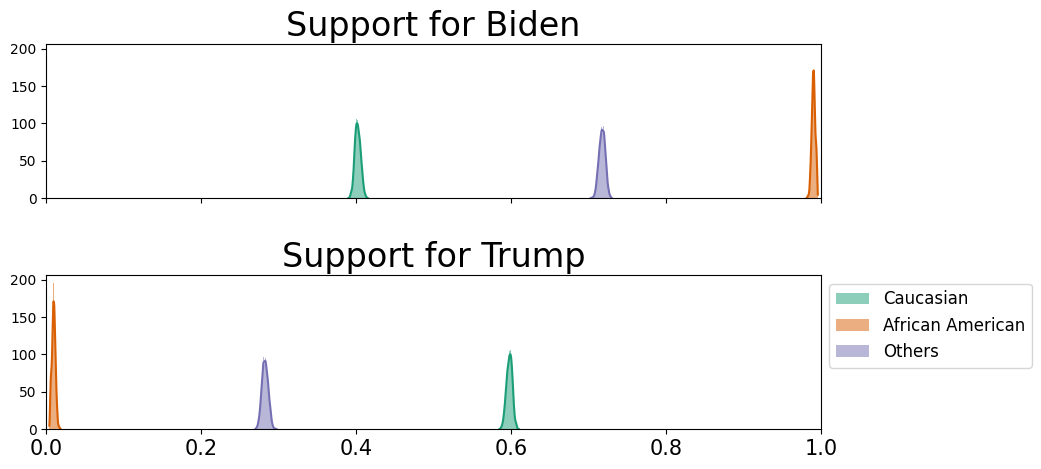

In [34]:
ei_rbyc.plot()

In [7]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Biden", "Trump"]
groups = ["caucasian", "african american", "other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "DELAWARE",
            "candidate": candidate,
            "race": group,
            "data": data.tolist(),  # Converting numpy array to Python list
            "election": "Presidential"
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)


In [8]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('DE_precincts_updated3.csv')
data = df.dropna()
data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK','DISTRICT','TOTAL_REG', 'POPULATION'], inplace=True)

data = data.dropna()
data.head()

C:\Users\danda\AppData\Local\Temp\ipykernel_16780\3194797610.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK','DISTRICT','TOTAL_REG', 'POPULATION'], inplace=True)


,OBJECTID,RDED,ETH1_EUR,ETH1_AA,rochester_votes,murphy_votes,total_votes,pct_rochester,pct_murphy,totalPop,pct_eur,pct_aa,pct_other
0,1,01-01,211,936,477.0,36.0,513.0,0.929825,0.070175,1177,0.179269,0.795242,0.025489
1,2,01-02,155,1310,569.0,29.0,598.0,0.951505,0.048495,1497,0.103540,0.875084,0.021376
2,3,01-03,83,1094,309.0,11.0,320.0,0.965625,0.034375,1194,0.069514,0.916248,0.014238
3,4,01-04,249,1224,439.0,26.0,465.0,0.944086,0.055914,1513,0.164574,0.808989,0.026438
4,5,01-05,589,826,719.0,99.0,818.0,0.878973,0.121027,1516,0.388522,0.544855,0.066623


In [9]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(data[['pct_eur','pct_aa', 'pct_other']]).T
votes_fractions = np.array(data[['pct_rochester', 'pct_murphy']]).T

group_fractions = np.round(group_fractions, decimals=6)
votes_fractions = np.round(votes_fractions, decimals=6)

negative_values = group_fractions[group_fractions < 0]
print("Negative values:", negative_values)

candidate_names_rbyc = ['Rochester', 'Murphy']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']

precinct_pops = np.array(data["totalPop"])
precinct_names = np.array(data['RDED'])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       precinct_names=precinct_names
)

Negative values: []
Running ['Caucasian', 'African American', 'Others'] x ['Rochester', 'Murphy'] EI
r = 3 rows (demographic groups)
c = 2 columns (candidates or voting outcomes)
number of precincts = 498


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'Support for Rochester'}>,
       <Axes: title={'center': 'Support for Murphy'}>], dtype=object)

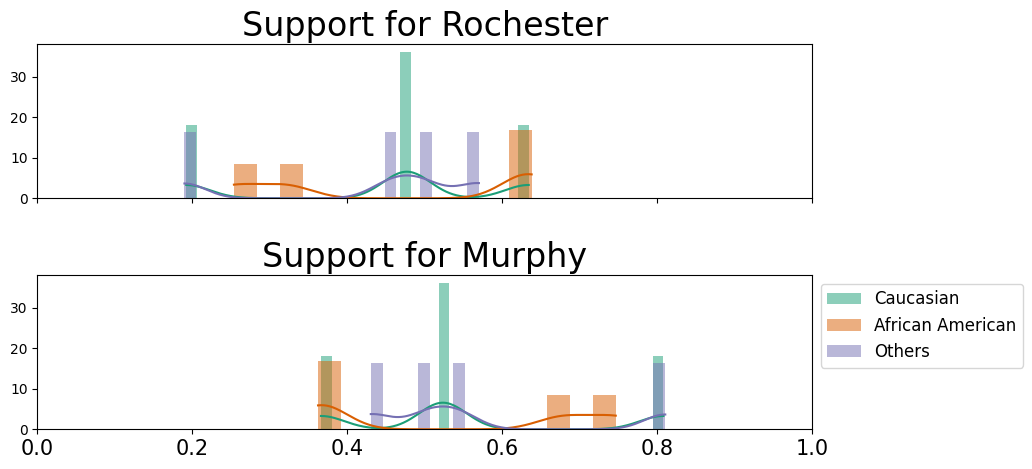

In [10]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
ei_rbyc.plot()

In [11]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Rochester", "Murphy"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "DELAWARE",
            "candidate": candidate,
            "race": group,
            "data": data.tolist(),  # Converting numpy array to Python list
            "election": "RepInCongress"
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)


In [12]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('AL_ei_data.csv')


columns_to_normalize = df[['pct_party_dem', 'pct_party_rep']]
row_sums = columns_to_normalize.sum(axis=1)
normalized_cols = columns_to_normalize.div(row_sums, axis=0)
df[['pct_party_dem', 'pct_party_rep']] = normalized_cols

columns_to_normalize = df[['pct_eth1_eur','pct_eth1_aa', 'pct_eth1_other']]
row_sums = columns_to_normalize.sum(axis=1)
normalized_cols = columns_to_normalize.div(row_sums, axis=0)
df[['pct_eth1_eur','pct_eth1_aa', 'pct_eth1_other']] = normalized_cols

df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df[:-21600]
print(df)

       Unnamed: 0  total_reg  party_rep  party_dem  eth1_eur  eth1_aa  \
1               1        533         59        471        86      444   
2               2        544        347        168       347      155   
3               3        336        163         53       286       22   
4               4        750        318        319       422      261   
5               5        232        152         56       170       42   
...           ...        ...        ...        ...       ...      ...   
18216       18216         44         27         12        30       11   
18228       18228         25          8         11        11       10   
18256       18256         88         75         10        81        3   
18262       18262         20         11          8        16        2   
18264       18264         24         16          7        20        1   

       party_other  eth1_other  pct_party_rep  pct_party_dem  pct_party_other  \
1                3           3       0.111

In [13]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(df[['pct_eth1_eur','pct_eth1_aa', 'pct_eth1_other']]).T
votes_fractions = np.array(df[['pct_party_dem', 'pct_party_rep']]).T

group_fractions = np.round(group_fractions, decimals=6)
votes_fractions = np.round(votes_fractions, decimals=6)

not1values = group_fractions[group_fractions != 1]
not1values2 = votes_fractions[votes_fractions != 1]
print("non1 values:", not1values)
print("non1 VALUES:", not1values2)

candidate_names_rbyc = ['Biden', 'Trump']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']

precinct_pops = np.array(df["total_reg"])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       #precinct_names=precinct_names
)


non1 values: [0.161351 0.637868 0.85119  ... 0.045455 0.1      0.125   ]
non1 VALUES: [0.888679 0.326214 0.24537  ... 0.882353 0.578947 0.695652]
Running ['Caucasian', 'African American', 'Others'] x ['Biden', 'Trump'] EI
r = 3 rows (demographic groups)
c = 2 columns (candidates or voting outcomes)
number of precincts = 2014


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'Support for Biden'}>,
       <Axes: title={'center': 'Support for Trump'}>], dtype=object)

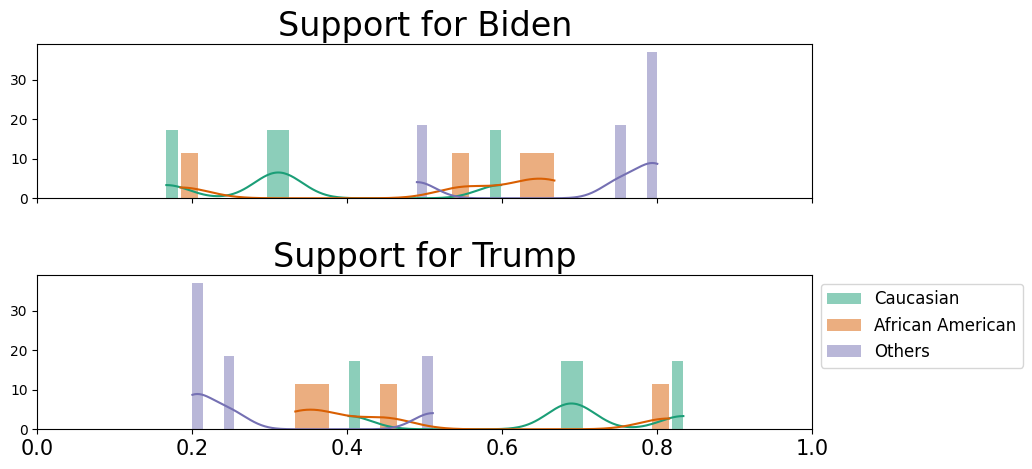

In [14]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
ei_rbyc.plot()

In [4]:
print(sampled_voting_prefs)

[[[6.91675530e-02 8.27416135e-01 1.03416312e-01]
  [9.87714567e-01 1.03337962e-02 1.95163716e-03]
  [2.17627066e-01 5.55702685e-01 2.26670249e-01]]

 [[7.18313805e-02 8.25306767e-01 1.02861852e-01]
  [9.87570528e-01 1.14830926e-02 9.46379679e-04]
  [2.13639391e-01 5.65594194e-01 2.20766415e-01]]

 [[6.63457682e-02 8.29346257e-01 1.04307974e-01]
  [9.89703154e-01 8.91462489e-03 1.38222107e-03]
  [2.14826889e-01 5.53984787e-01 2.31188324e-01]]

 ...

 [[7.71694791e-02 8.21151154e-01 1.01679367e-01]
  [9.88659074e-01 1.07619641e-02 5.78962156e-04]
  [2.02125333e-01 5.62402556e-01 2.35472111e-01]]

 [[7.24110304e-02 8.22479069e-01 1.05109901e-01]
  [9.89358203e-01 9.93482350e-03 7.06973919e-04]
  [1.95598275e-01 5.69586001e-01 2.34815724e-01]]

 [[7.25693214e-02 8.25956079e-01 1.01474600e-01]
  [9.89523313e-01 9.93052258e-03 5.46164645e-04]
  [1.97222839e-01 5.65584570e-01 2.37192591e-01]]]


In [15]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Biden", "Trump"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "ALABAMA",
            "candidate": candidate,
            "race": group,
            "data": data.tolist(),  # Converting numpy array to Python list
            "election": "Presidential"
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)


In [16]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('AL_countydata.csv')
print(df)

    voted_for_flowers  voted_for_ivey  votecount  voted_eur  voted_aa  \
0                3515           13387      16902      13547      2865   
1               10296           58823      69119      62056      3215   
2                2549            3888       6437       3759      2433   
3                 930            4681       5611       4765       786   
4                 930           14895      15825      15252       180   
..                ...             ...        ...        ...       ...   
61              17937           31841      49778      34855     13394   
62               1905           15217      17122      15489       901   
63               1206            4584       5790       4260      1159   
64               2489            1371       3860       1048      2684   
65                344            6331       6675       6464        22   

    voted_oth  pct_flowers  pct_ivey  pct_eth_eur  pct_eth_aa  pct_eth_oth  
0         490     0.207964  0.792036     0.801

In [17]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(df[['pct_eth_eur','pct_eth_aa', 'pct_eth_oth']]).T
votes_fractions = np.array(df[['pct_flowers', 'pct_ivey']]).T


candidate_names_rbyc = ['Flowers', 'Ivey']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']


precinct_pops = np.array(df["votecount"])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       #precinct_names=precinct_names
)

Running ['Caucasian', 'African American', 'Others'] x ['Flowers', 'Ivey'] EI
r = 3 rows (demographic groups)
c = 2 columns (candidates or voting outcomes)
number of precincts = 66


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'Support for Flowers'}>,
       <Axes: title={'center': 'Support for Ivey'}>], dtype=object)

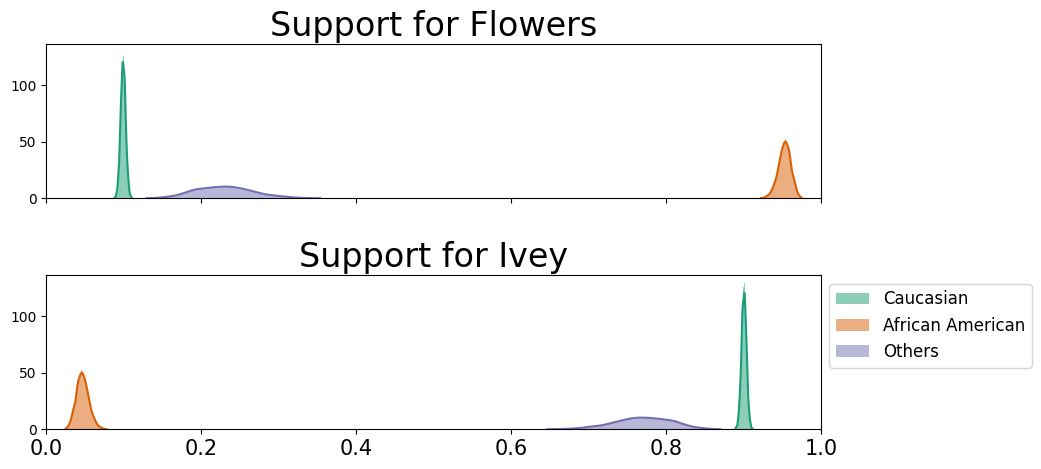

In [18]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
ei_rbyc.plot()

In [9]:
print(sampled_voting_prefs)

[[[8.56656865e-02 8.62479460e-01 5.18548536e-02]
  [9.50328754e-01 4.78058549e-02 1.86539116e-03]
  [2.49748698e-01 7.13273298e-01 3.69780044e-02]]

 [[9.09754562e-02 8.57734618e-01 5.12899256e-02]
  [9.47614788e-01 5.00678958e-02 2.31731570e-03]
  [1.98638432e-01 7.59647628e-01 4.17139404e-02]]

 [[9.16106686e-02 8.59304489e-01 4.90848429e-02]
  [9.41825601e-01 5.50315951e-02 3.14280376e-03]
  [2.13937463e-01 7.35441882e-01 5.06206545e-02]]

 ...

 [[8.71938360e-02 8.64478923e-01 4.83272406e-02]
  [9.55555288e-01 4.19951214e-02 2.44959079e-03]
  [2.12445837e-01 7.22914425e-01 6.46397372e-02]]

 [[8.12183847e-02 8.71223713e-01 4.75579027e-02]
  [9.47924861e-01 5.12464145e-02 8.28724036e-04]
  [2.89526654e-01 6.41140652e-01 6.93326941e-02]]

 [[8.52587918e-02 8.63640109e-01 5.11010996e-02]
  [9.53421954e-01 4.60436166e-02 5.34429677e-04]
  [2.48472762e-01 7.08254797e-01 4.32724412e-02]]]


In [19]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Flowers", "Ivey"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "ALABAMA",
            "candidate": candidate,
            "race": group,
            "data": data.tolist(),  # Converting numpy array to Python list
            "election": "Governor"
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)


In [3]:
import geopandas as gpd
de_prec = gpd.read_file('DE_precincts.geojson')
de_prec = de_prec[de_prec['TOTAL_REG'] != 0]
de_districts = de_prec.dissolve(by='DISTRICT', aggfunc={
    "ETH1_EUR": 'sum', "ETH1_HISP": 'sum', "ETH1_AA": 'sum', "ETH1_ESA": 'sum', "ETH1_UNK": 'sum',
    "VOTERS_GENDER_M": 'sum', "VOTERS_GENDER_F": 'sum', "VOTERS_GENDER_UNKNOWN": 'sum', "PARTY_DEM": 'sum',
    "PARTY_REP": 'sum', "PARTY_OTHER": 'sum', "POPULATION": 'sum'
})
ideal_pop = np.sum(de_districts['POPULATION'])/ 41
print(int(ideal_pop))

total_pop = np.sum(de_districts['POPULATION'])
print(int(total_pop))

minority_pop_aa = np.sum(de_districts['ETH1_AA'])
minority_pop_eur = np.sum(de_districts['ETH1_EUR'])

max_opp_districts_aa = minority_pop_aa / (.5 * ideal_pop)

max_opp_districts_eur = minority_pop_eur / (.5 * ideal_pop)

print(int(max_opp_districts_aa))
print(int(max_opp_districts_eur))

print("aa ",minority_pop_aa)
print("eur",minority_pop_eur)

24145
989948
11
36
aa  143365
eur 445626


In [4]:
import geopandas as gpd
de_prec = gpd.read_file('AL_precincts.geojson')
de_prec = de_prec[de_prec['TOTAL_REG'] != 0]
de_districts = de_prec.dissolve(by='DISTRICT', aggfunc={
    "ETH1_EUR": 'sum', "ETH1_HISP": 'sum', "ETH1_AA": 'sum', "ETH1_ESA": 'sum', "ETH1_UNK": 'sum',
    "VOTERS_GENDER_M": 'sum', "VOTERS_GENDER_F": 'sum', "VOTERS_GENDER_UNKNOWN": 'sum', "PARTY_DEM": 'sum',
    "PARTY_REP": 'sum', "PARTY_OTHER": 'sum', "POPULATION": 'sum'
})
ideal_pop = np.sum(de_districts['POPULATION'])/ 41
print(int(ideal_pop))

total_pop = np.sum(de_districts['POPULATION'])
print(int(total_pop))

minority_pop_aa = np.sum(de_districts['ETH1_AA'])
minority_pop_eur = np.sum(de_districts['ETH1_EUR'])

max_opp_districts_aa = minority_pop_aa / (.5 * ideal_pop)

max_opp_districts_eur = minority_pop_eur / (.5 * ideal_pop)

print(int(max_opp_districts_aa))
print(int(max_opp_districts_eur))

print("aa ",minority_pop_aa)
print("eur",minority_pop_eur)

122543
5024279
15
35
aa  926476.0
eur 2197450.0


In [4]:
# SOURCED FROM: https://github.com/jeffreyshen19/Seats-Votes-Curves/blob/master/generator/uniform_partisan_swing.py
# MODIFIED FOR MINORITY GROUP INSTEAD OF POLITICAL

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import random

# Now you can import GeoPandas
import geopandas as gpd


def vote_seat_shares(districts):
    votingByDistrict = []
    seatsVotesWht = []
    seatsVotesBlk = []

    SWING_CONST = 0.01  # Percentage to increase each district by

    total_votes = 0
    total_blk_votes = 0
    total_wht_votes = 0

    # Read all district data
    blk = np.sum(districts['ETH1_AA'])
    wht = np.sum(districts['ETH1_EUR'])
    total = wht + blk

    total_votes += total
    total_blk_votes += blk
    total_wht_votes += wht
    percentWht = float(wht) / total

    votingByDistrict.append({"percentWht": percentWht, "percentBlk": 1.0 - percentWht})

    WhtVoteShare = float(total_wht_votes) / total_votes
    BlkVoteShare = float(total_blk_votes) / total_votes

    diff = (((100 * WhtVoteShare) % 1) - ((100 * BlkVoteShare) % 1)) / 100  #

    # Generate curve
    i = WhtVoteShare
    counter = 0
    while i <= 1:
        totalWhtSeats = 0
        totalBlkSeats = 0
        for j in range(0, 1000):  # simulate 1000 elections

            districtOverflowedWht = [False] * len(votingByDistrict);
            districtOverflowedBlk = [False] * len(votingByDistrict);
            excessBlk = 0
            excessWht = 0
            updatedValsWht = [0] * len(votingByDistrict);
            updatedValsBlk = [0] * len(votingByDistrict);

            for k, district in enumerate(votingByDistrict):
                updatedValsWht[k] = district["percentWht"] + counter * SWING_CONST + SWING_CONST * random.randint(-5, 5)
                updatedValsBlk[k] = 1 - updatedValsWht[k] + diff

                if updatedValsWht[k] > 1:
                    excessWht += 1
                    districtOverflowedWht[k] = True

                if updatedValsBlk[k] < 0:
                    excessBlk += 1
                    districtOverflowedBlk[k] = True

            for k, district in enumerate(votingByDistrict):
                # Overflow mechanic: distribute excess votes to the other districts
                if districtOverflowedWht[k] is False:
                    updatedValsWht[k] += SWING_CONST * (excessWht / (len(votingByDistrict) - excessWht))

                if districtOverflowedBlk[k] is False:
                    updatedValsBlk[k] -= SWING_CONST * (excessBlk / (len(votingByDistrict) - excessBlk))

                if updatedValsWht[k] > 0.50:
                    totalWhtSeats += 1
                if updatedValsBlk[k] > 0.50:
                    totalBlkSeats += 1

        i += SWING_CONST
        counter += 1

        if i <= 1:
            seatsVotesWht.append({"seats": float(totalWhtSeats) / (len(votingByDistrict) * 1000.0), "votes": i})
            seatsVotesBlk.insert(0, {"seats": float(totalBlkSeats) / (len(votingByDistrict) * 1000.0),
                                     "votes": 1 - i + diff})

    i = BlkVoteShare
    counter = 0

    while i <= 1:
        totalBlkSeats = 0
        totalWhtSeats = 0

        for j in range(0, 1000):  # simulate 1000 elections
            districtOverflowedWht = [False] * len(votingByDistrict);
            districtOverflowedBlk = [False] * len(votingByDistrict);
            excessBlk = 0
            excessWht = 0
            updatedValsWht = [0] * len(votingByDistrict);
            updatedValsBlk = [0] * len(votingByDistrict);

            for k, district in enumerate(votingByDistrict):
                updatedValsBlk[k] = district["percentBlk"] + counter * SWING_CONST + SWING_CONST * random.randint(-5,
                                                                                                                  5) + diff
                updatedValsWht[k] = 1 - (updatedValsBlk[k] - diff)

                if updatedValsWht[k] > 1:
                    excessWht += 1
                    districtOverflowedWht[k] = True

                if updatedValsBlk[k] < 0:
                    excessBlk += 1
                    districtOverflowedBlk[k] = True

            for k, district in enumerate(votingByDistrict):
                # Overflow mechanic: distribute excess votes to the other districts
                if districtOverflowedWht[k] is False:
                    updatedValsWht[k] -= SWING_CONST * (excessWht / (len(votingByDistrict) - excessWht))

                if districtOverflowedBlk[k] is False:
                    updatedValsBlk[k] += SWING_CONST * (excessBlk / (len(votingByDistrict) - excessBlk))

                if updatedValsWht[k] > 0.50:
                    totalWhtSeats += 1
                if updatedValsBlk[k] > 0.50:
                    totalBlkSeats += 1

        i += SWING_CONST
        counter += 1

        if i <= 1:
            seatsVotesBlk.append({"seats": float(totalBlkSeats) / (len(votingByDistrict) * 1000.0), "votes": i + diff})
            seatsVotesWht.insert(0, {"seats": float(totalWhtSeats) / (len(votingByDistrict) * 1000.0), "votes": 1 - i})

    # Add endpoints
    seatsVotesWht.insert(0, {"seats": 0, "votes": 0})
    seatsVotesBlk.insert(0, {"seats": 0, "votes": 0})
    seatsVotesWht.append({"seats": 1, "votes": 1})
    seatsVotesBlk.append({"seats": 1, "votes": 1})
    
    return seatsVotesWht, seatsVotesBlk
    
if __name__ == '__main__':
    de_prec = gpd.read_file('DE_precincts.geojson')
    de_prec = de_prec[de_prec['TOTAL_REG'] != 0]
    de_districts = de_prec.dissolve(by='DISTRICT', aggfunc={
        "ETH1_EUR": 'sum', "ETH1_HISP": 'sum', "ETH1_AA": 'sum', "ETH1_ESA": 'sum', "ETH1_UNK": 'sum',
        "VOTERS_GENDER_M": 'sum', "VOTERS_GENDER_F": 'sum', "VOTERS_GENDER_UNKNOWN": 'sum', "PARTY_DEM": 'sum',
        "PARTY_REP": 'sum', "PARTY_OTHER": 'sum', "POPULATION": 'sum'
    })

    de_wht_arr, de_blk_arr = vote_seat_shares(de_districts)

    # Plotting
    votes_blk = [entry['votes'] for entry in de_blk_arr]

    # Extracting just the 'seats'
    seats_blk = [entry['seats'] for entry in de_blk_arr]

    votes_wht = [entry['votes'] for entry in de_wht_arr]

    # Extracting just the 'seats'
    seats_wht = [entry['seats'] for entry in de_wht_arr]
    
    plt.plot(votes_blk, seats_blk, color='blue', label='Black')
    plt.plot(votes_wht, seats_wht, color='red', label='White')

    # Adding labels and title
    plt.xlabel('Vote Share')
    plt.ylabel('Seat Share')
    plt.title('Vote Seat Share')
    plt.legend()

    plt.ylim(0, 1)

    # Displaying the plot
    plt.show()


In [1]:
# SOURCED FROM: https://github.com/jeffreyshen19/Seats-Votes-Curves/blob/master/generator/uniform_partisan_swing.py
# MODIFIED FOR MINORITY GROUP INSTEAD OF POLITICAL

import numpy as np
import pandas as pd
import matplotlib

matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import random

# Now you can import GeoPandas
import geopandas as gpd


def vote_seat_shares(districts):
    votingByDistrict = []
    seatsVotesWht = []
    seatsVotesBlk = []

    SWING_CONST = 0.001  # Percentage to increase each district by

    total_votes = 0
    total_blk_votes = 0
    total_wht_votes = 0

    # Read all district data
    blk = np.sum(districts['ETH1_AA'])
    wht = np.sum(districts['ETH1_EUR'])
    total = wht + blk

    total_votes += total
    total_blk_votes += blk
    total_wht_votes += wht
    percentWht = float(wht) / total
    percentBlk = float(blk) / total

    votingByDistrict.append({"percentWht": percentWht, "percentBlk": percentBlk})

    WhtVoteShare = float(total_wht_votes) / total_votes
    BlkVoteShare = float(total_blk_votes) / total_votes

    diff = (((100 * WhtVoteShare) % 1) - ((100 * BlkVoteShare) % 1)) / 100  #

    # Generate curve
    i = WhtVoteShare
    counter = 0
    while i <= 1:
        totalWhtSeats = 0
        totalBlkSeats = 0
        for j in range(0, 1000):  # simulate 1000 elections

            districtOverflowedWht = [False] * len(votingByDistrict);
            districtOverflowedBlk = [False] * len(votingByDistrict);
            excessBlk = 0
            excessWht = 0
            updatedValsWht = [0] * len(votingByDistrict);
            updatedValsBlk = [0] * len(votingByDistrict);

            for k, district in enumerate(votingByDistrict):
                updatedValsWht[k] = district["percentWht"] + counter * SWING_CONST + \
                                    SWING_CONST * random.randint(-5, 5)
                updatedValsBlk[k] = 1 - updatedValsWht[k] + diff

                if updatedValsWht[k] > 1:
                    excessWht += 1
                    districtOverflowedWht[k] = True

                if updatedValsBlk[k] < 0:
                    excessBlk += 1
                    districtOverflowedBlk[k] = True

            for k, district in enumerate(votingByDistrict):
                # Overflow mechanic: distribute excess votes to the other districts
                if districtOverflowedWht[k] is False:
                    updatedValsWht[k] += SWING_CONST * (excessWht / (len(votingByDistrict) - excessWht))

                if districtOverflowedBlk[k] is False:
                    updatedValsBlk[k] -= SWING_CONST * (excessBlk / (len(votingByDistrict) - excessBlk))

                if updatedValsWht[k] > 0.50:
                    totalWhtSeats += 1
                if updatedValsBlk[k] > 0.50:
                    totalBlkSeats += 1

        i += SWING_CONST
        counter += 1

        if i <= 1:
            seatsVotesWht.append({"seats": float(totalWhtSeats) / (len(votingByDistrict) * 1000.0), "votes": i})
            seatsVotesBlk.insert(0, {"seats": float(totalBlkSeats) / (len(votingByDistrict) * 1000.0),
                                     "votes": 1 - i + diff})

    i = BlkVoteShare
    counter = 0

    while i <= 1:
        totalBlkSeats = 0
        totalWhtSeats = 0

        for j in range(0, 1000):  # simulate 1000 elections
            districtOverflowedWht = [False] * len(votingByDistrict);
            districtOverflowedBlk = [False] * len(votingByDistrict);
            excessBlk = 0
            excessWht = 0
            updatedValsWht = [0] * len(votingByDistrict);
            updatedValsBlk = [0] * len(votingByDistrict);

            for k, district in enumerate(votingByDistrict):
                updatedValsBlk[k] = district["percentBlk"] + counter * SWING_CONST + \
                                    SWING_CONST * random.randint(-5,5) + diff
                updatedValsWht[k] = 1 - (updatedValsBlk[k] - diff)

                if updatedValsWht[k] > 1:
                    excessWht += 1
                    districtOverflowedWht[k] = True

                if updatedValsBlk[k] < 0:
                    excessBlk += 1
                    districtOverflowedBlk[k] = True

            for k, district in enumerate(votingByDistrict):
                # Overflow mechanic: distribute excess votes to the other districts
                if districtOverflowedWht[k] is False:
                    updatedValsWht[k] -= SWING_CONST * (excessWht / (len(votingByDistrict) - excessWht))

                if districtOverflowedBlk[k] is False:
                    updatedValsBlk[k] += SWING_CONST * (excessBlk / (len(votingByDistrict) - excessBlk))

                if updatedValsWht[k] > 0.50:
                    totalWhtSeats += 1
                if updatedValsBlk[k] > 0.50:
                    totalBlkSeats += 1

        i += SWING_CONST
        counter += 1

        if i <= 1:
            seatsVotesBlk.append({"seats": float(totalBlkSeats) / (len(votingByDistrict) * 1000.0), 
                                  "votes": i + diff})
            seatsVotesWht.insert(0, {"seats": float(totalWhtSeats) / (len(votingByDistrict) * 1000.0), 
                                     "votes": 1 - i})

    # Add endpoints
    seatsVotesWht.insert(0, {"seats": 0, "votes": 0})
    seatsVotesBlk.insert(0, {"seats": 0, "votes": 0})
    seatsVotesWht.append({"seats": 1, "votes": 1})
    seatsVotesBlk.append({"seats": 1, "votes": 1})

    return seatsVotesWht, seatsVotesBlk


if __name__ == '__main__':
    de_prec = gpd.read_file('DE_precincts.geojson')
    de_prec = de_prec[de_prec['TOTAL_REG'] != 0]
    de_districts = de_prec.dissolve(by='DISTRICT', aggfunc={
        "ETH1_EUR": 'sum', "ETH1_HISP": 'sum', "ETH1_AA": 'sum', "ETH1_ESA": 'sum', "ETH1_UNK": 'sum',
        "VOTERS_GENDER_M": 'sum', "VOTERS_GENDER_F": 'sum', "VOTERS_GENDER_UNKNOWN": 'sum', "PARTY_DEM": 'sum',
        "PARTY_REP": 'sum', "PARTY_OTHER": 'sum', "POPULATION": 'sum'
    })

    de_wht_arr, de_blk_arr = vote_seat_shares(de_districts)

    # extracting data
    votes_blk = [entry['votes'] for entry in de_blk_arr]
    seats_blk = [entry['seats'] for entry in de_blk_arr]

    # extracting data
    votes_wht = [entry['votes'] for entry in de_wht_arr]
    seats_wht = [entry['seats'] for entry in de_wht_arr]

    plt.plot(votes_blk, seats_blk, color='blue', label='Black')
    plt.plot(votes_wht, seats_wht, color='red', label='White')

    # Adding labels and title
    plt.xlabel('Vote Share')
    plt.ylabel('Seat Share')
    plt.title('Vote Seat Share')
    plt.legend()

    plt.ylim(0, 1)

    # Displaying the plot
    plt.show()
